# Лекция №9

## На прошлой лекции

[Salome](#salome)

[Paraview](#paraview)

[cfMesh](#cfmesh)

## План
1. [dynamicMotionSolverFvMesh](#motion)
2. [Конвекция](#conv)
3. [Градиент](#grad)

## Метод контрольного объема (Finite Volume Method) <a name="FVM"></a>

<img src="img/finite_volume.png" width="1000" height="200">

Уравнение переноса в интегральной форме:

$$
\int_V {\partial{\rho \phi}\over {\partial t}} dV + \int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV = \int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV + \int_V S_\phi dV
$$

$dV$ - элементарный объем (ячейка сетки) "картинка ячейки"

$\phi$ - объемное поле (volScalarField) ($\rho,\rho U,\rho E, T$)

$\vec U$ - объемное поле скорости

$\rho$ - объемное поле плотности

$\Gamma$ - объемное поле коэффициента диффузии

$S_\phi$ - объемное поле источника

<img src="img/cell.png" width="300" height="200">

[FVM wolfdynamics](../books/wd_fvm.pdf) p.12

[ProgrammerGuide](../books/OFpg.pdf) p.25

Производная по времени:

$$\int_V {\partial{\rho \phi}\over {\partial t}} dV \approx ({\partial{\rho \phi}\over {\partial t}})_P V_p$$

Источник:
$$\int_V S_\phi dV \approx S_{\phi P} V_P$$

Источник и производная по времени: только объемные поля (volScalarField), нет связи с соседними ячейками

Теорема Остроградского-Гаусса:

$$\int_V \left( \nabla \cdot \vec u \right) dV = \oint_S \left( \vec{n} \cdot \vec u \right) dS \approx
\sum\limits_{face} \left( \vec{n} \cdot \vec u \right)_f S_f
$$

Конвекция:

$$\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

Диффузия:

$$\int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV \approx
\sum\limits_{face} \left(\Gamma \nabla \phi  \cdot \vec{n} \right)_f S_f$$

Конвекция и диффузия: поля на гранях (surfaceScalarField), связь с соседними ячейками

## dynamicMotionSolverFvMesh <a name="motion"></a> 

[DynamicMesh OpenFOAM Jasak](../books/dynamicMesh_jasak.pdf) - статья про динамические сетки в OpenFOAM

* dynamicRefineFvMesh - дробление гексаэдральных ячеек
* dynamicMotionSolverFvMesh - движение узлов без изменения топологии сетки
* dynamicOversetFvMesh - перекрывающиеся сетки

dynamicMotionSolverFvMesh

Границы сетки двигаются. Что делать с ячейками внутри сетки?

Сглаживающий оператор!

Краевая задача для поля перемещений!

$$\nabla \mu (\nabla \vec x) = 0$$
$$\vec x_{\partial S} = \vec x_0$$

$\vec x$ - displacement field (поле перемещений)

$\mu$ - поле вязкости для контроля относительного перемещения узлов внутри сетки

* решаем уравнение для объемного поля
* интерпалируем значения на узлы
* находим новые значения координат узлов сетки

In [1]:
!ls $WM_PROJECT_DIR/src/fvMotionSolver/fvMotionSolvers/

componentDisplacement  displacement    velocity
componentVelocity      fvMotionSolver


In [2]:
!ls $WM_PROJECT_DIR/src/fvMotionSolver/fvMotionSolvers/displacement

laplacian  SBRStress  solidBodyDisplacementLaplacian  surfaceAlignedSBRStress


In [ ]:
#!cat $WM_PROJECT_DIR/src/fvMotionSolver/fvMotionSolvers/displacement/laplacian/displacementLaplacianFvMotionSolver.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2017 OpenFOAM Foundation
    Copyright (C) 2015-2020 OpenCFD Ltd.
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

\*---------------------------------------------------------------------------*/

#include "displacementLaplacianFvMotionSolver.H"
#include "motionInterpolation.H"
#include "motionDiffusivity.H"
#include "fvmLaplacian.H"
#include "addToRunTimeSelectionTable.H"
#include "OFstream.H"
#include "meshTools.H"
#include "mapPolyMesh.H"
#include "fvOptions.H"

// * * * * * * * * * * * * * * Static Data Members * * * * * * * * * * * * * //

namespace Foam
{
    defineTypeNameAndDebug(displacementLaplacianFvMotionSolver, 0);

    addToRunTimeSelectionTable
    (
        motionSolver,
        displacementLaplacianFvMotionSolver,
        dictionary
    );

    addToRunTimeSelectionTable
    (
        displacementMotionSolver,
        displacementLaplacianFvMotionSolver,
        displacement
    );
}


// * * * * * * * * * * * * * * * * Constructors  * * * * * * * * * * * * * * //

Foam::displacementLaplacianFvMotionSolver::displacementLaplacianFvMotionSolver
(
    const polyMesh& mesh,
    const IOdictionary& dict
)
:
    displacementMotionSolver(mesh, dict, typeName),
    fvMotionSolver(mesh),
    cellDisplacement_
    (
        IOobject
        (
            "cellDisplacement",
            mesh.time().timeName(),
            mesh,
            IOobject::READ_IF_PRESENT,
            IOobject::AUTO_WRITE
        ),
        fvMesh_,
        dimensionedVector(pointDisplacement_.dimensions(), Zero),
        cellMotionBoundaryTypes<vector>(pointDisplacement_.boundaryField())
    ),
    pointLocation_(nullptr),
    interpolationPtr_
    (
        coeffDict().found("interpolation")
      ? motionInterpolation::New(fvMesh_, coeffDict().lookup("interpolation"))
      : motionInterpolation::New(fvMesh_)
    ),
    diffusivityPtr_
    (
        motionDiffusivity::New(fvMesh_, coeffDict().lookup("diffusivity"))
    ),
    frozenPointsZone_
    (
        coeffDict().found("frozenPointsZone")
      ? fvMesh_.pointZones().findZoneID
        (
            coeffDict().get<word>("frozenPointsZone")
        )
      : -1
    )
{
    IOobject io
    (
        "pointLocation",
        fvMesh_.time().timeName(),
        fvMesh_,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    );

    if (debug)
    {
        Info<< "displacementLaplacianFvMotionSolver:" << nl
            << "    diffusivity       : " << diffusivityPtr_().type() << nl
            << "    frozenPoints zone : " << frozenPointsZone_ << endl;
    }


    if (io.typeHeaderOk<pointVectorField>(true))
    {
        pointLocation_.reset
        (
            new pointVectorField
            (
                io,
                pointMesh::New(fvMesh_)
            )
        );

        if (debug)
        {
            Info<< "displacementLaplacianFvMotionSolver :"
                << " Read pointVectorField "
                << io.name()
                << " to be used for boundary conditions on points."
                << nl
                << "Boundary conditions:"
                << pointLocation_().boundaryField().types() << endl;
        }
    }
}


Foam::displacementLaplacianFvMotionSolver::
displacementLaplacianFvMotionSolver
(
    const polyMesh& mesh,
    const IOdictionary& dict,
    const pointVectorField& pointDisplacement,
    const pointIOField& points0
)
:
    displacementMotionSolver(mesh, dict, pointDisplacement, points0, typeName),
    fvMotionSolver(mesh),
    cellDisplacement_
    (
        IOobject
        (
            "cellDisplacement",
            mesh.time().timeName(),
            mesh,
            IOobject::READ_IF_PRESENT,
            IOobject::AUTO_WRITE
        ),
        fvMesh_,
        dimensionedVector(pointDisplacement_.dimensions(), Zero),
        cellMotionBoundaryTypes<vector>(pointDisplacement_.boundaryField())
    ),
    pointLocation_(nullptr),
    interpolationPtr_
    (
        coeffDict().found("interpolation")
      ? motionInterpolation::New(fvMesh_, coeffDict().lookup("interpolation"))
      : motionInterpolation::New(fvMesh_)
    ),
    diffusivityPtr_
    (
        motionDiffusivity::New(fvMesh_, coeffDict().lookup("diffusivity"))
    ),
    frozenPointsZone_
    (
        coeffDict().found("frozenPointsZone")
      ? fvMesh_.pointZones().findZoneID
        (
            coeffDict().get<word>("frozenPointsZone")
        )
      : -1
    )
{
    IOobject io
    (
        "pointLocation",
        fvMesh_.time().timeName(),
        fvMesh_,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    );

    if (debug)
    {
        Info<< "displacementLaplacianFvMotionSolver:" << nl
            << "    diffusivity       : " << diffusivityPtr_().type() << nl
            << "    frozenPoints zone : " << frozenPointsZone_ << endl;
    }


    if (io.typeHeaderOk<pointVectorField>(true))
    {
        pointLocation_.reset
        (
            new pointVectorField
            (
                io,
                pointMesh::New(fvMesh_)
            )
        );

        if (debug)
        {
            Info<< "displacementLaplacianFvMotionSolver :"
                << " Read pointVectorField "
                << io.name()
                << " to be used for boundary conditions on points."
                << nl
                << "Boundary conditions:"
                << pointLocation_().boundaryField().types() << endl;
        }
    }
}


// * * * * * * * * * * * * * * * * Destructor  * * * * * * * * * * * * * * * //

Foam::displacementLaplacianFvMotionSolver::
~displacementLaplacianFvMotionSolver()
{}


// * * * * * * * * * * * * * * * Member Functions  * * * * * * * * * * * * * //

Foam::motionDiffusivity&
Foam::displacementLaplacianFvMotionSolver::diffusivity()
{
    if (!diffusivityPtr_)
    {
        diffusivityPtr_ = motionDiffusivity::New
        (
            fvMesh_,
            coeffDict().lookup("diffusivity")
        );
    }

    return *diffusivityPtr_;
}


Foam::tmp<Foam::pointField>
Foam::displacementLaplacianFvMotionSolver::curPoints() const
{
    interpolationPtr_->interpolate
    (
        cellDisplacement_,
        pointDisplacement_
    );

    if (pointLocation_)
    {
        if (debug)
        {
            Info<< "displacementLaplacianFvMotionSolver : applying "
                << " boundary conditions on " << pointLocation_().name()
                << " to new point location."
                << endl;
        }

        pointLocation_().primitiveFieldRef() =
            points0()
          + pointDisplacement_.primitiveField();

        pointLocation_().correctBoundaryConditions();

        // Implement frozen points
        if (frozenPointsZone_ != -1)
        {
            const pointZone& pz = fvMesh_.pointZones()[frozenPointsZone_];

            forAll(pz, i)
            {
                pointLocation_()[pz[i]] = points0()[pz[i]];
            }
        }

        twoDCorrectPoints(pointLocation_().primitiveFieldRef());

        return tmp<pointField>(pointLocation_().primitiveField());
    }
    else
    {
        tmp<pointField> tcurPoints
        (
            points0() + pointDisplacement_.primitiveField()
        );
        pointField& curPoints = tcurPoints.ref();

        // Implement frozen points
        if (frozenPointsZone_ != -1)
        {
            const pointZone& pz = fvMesh_.pointZones()[frozenPointsZone_];

            forAll(pz, i)
            {
                curPoints[pz[i]] = points0()[pz[i]];
            }
        }

        twoDCorrectPoints(curPoints);

        return tcurPoints;
    }
}


void Foam::displacementLaplacianFvMotionSolver::solve()
{
    // The points have moved so before interpolation update
    // the motionSolver accordingly
    movePoints(fvMesh_.points());

    diffusivity().correct();
    pointDisplacement_.boundaryFieldRef().updateCoeffs();

    fv::options& fvOptions(fv::options::New(fvMesh_));

    // We explicitly do NOT want to interpolate the motion inbetween
    // different regions so bypass all the matrix manipulation.
    fvVectorMatrix TEqn
    (
        fvm::laplacian
        (
            dimensionedScalar("viscosity", dimViscosity, 1.0)
           *diffusivity().operator()(),
            cellDisplacement_,
            "laplacian(diffusivity,cellDisplacement)"
        )
     ==
        fvOptions(cellDisplacement_)
    );

    fvOptions.constrain(TEqn);
    TEqn.solveSegregatedOrCoupled(TEqn.solverDict());
    fvOptions.correct(cellDisplacement_);
}


void Foam::displacementLaplacianFvMotionSolver::updateMesh
(
    const mapPolyMesh& mpm
)
{
    displacementMotionSolver::updateMesh(mpm);

    // Update diffusivity. Note two stage to make sure old one is de-registered
    // before creating/registering new one.
    diffusivityPtr_.clear();
}


// ************************************************************************* //
```

In [ ]:
# dynamicFvMesh + mesh.update()
#!cat $WM_PROJECT_DIR/applications/utilities/mesh/manipulation/moveDynamicMesh/moveDynamicMesh.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
    Copyright (C) 2016-2020 OpenCFD Ltd.
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    moveDynamicMesh

Group
    grpMeshManipulationUtilities

Description
    Mesh motion and topological mesh changes utility.

\*---------------------------------------------------------------------------*/

#include "argList.H"
#include "Time.H"
#include "dynamicFvMesh.H"
#include "pimpleControl.H"
#include "cyclicAMIPolyPatch.H"
#include "PatchTools.H"
#include "foamVtkSurfaceWriter.H"
#include "functionObject.H"

using namespace Foam;

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

// Dump patch + weights to vtk file
void writeWeights
(
    const polyMesh& mesh,
    const scalarField& wghtSum,
    const primitivePatch& patch,
    const fileName& directory,
    const fileName& prefix,
    const Time& runTime
)
{
    // Collect geometry
    labelList pointToGlobal;
    labelList uniqueMeshPointLabels;
    autoPtr<globalIndex> globalPoints;
    autoPtr<globalIndex> globalFaces;
    faceList mergedFaces;
    pointField mergedPoints;
    Foam::PatchTools::gatherAndMerge
    (
        mesh,
        patch.localFaces(),
        patch.meshPoints(),
        patch.meshPointMap(),

        pointToGlobal,
        uniqueMeshPointLabels,
        globalPoints,
        globalFaces,

        mergedFaces,
        mergedPoints
    );

    // Collect field
    scalarField mergedWeights;
    globalFaces().gather(wghtSum, mergedWeights);

    instant inst(runTime.value(), runTime.timeName());

    if (Pstream::master())
    {
        vtk::surfaceWriter writer
        (
            mergedPoints,
            mergedFaces,
            (directory/prefix + "_" + inst.name()),
            false // serial: master-only
        );

        writer.setTime(inst);
        writer.writeTimeValue();
        writer.writeGeometry();

        writer.beginCellData(1);
        writer.write("weightsSum", mergedWeights);
    }
}


void writeWeights(const polyMesh& mesh)
{
    const fileName outputDir
    (
        mesh.time().globalPath()/functionObject::outputPrefix/"checkAMI"
    );

    for (const polyPatch& pp : mesh.boundaryMesh())
    {
        if (isA<cyclicAMIPolyPatch>(pp))
        {
            const cyclicAMIPolyPatch& cpp =
                refCast<const cyclicAMIPolyPatch>(pp);

            if (cpp.owner())
            {
                Info<< "Calculating AMI weights between owner patch: "
                    << cpp.name() << " and neighbour patch: "
                    << cpp.neighbPatch().name() << endl;

                const AMIPatchToPatchInterpolation& ami =
                    cpp.AMI();

                writeWeights
                (
                    mesh,
                    ami.tgtWeightsSum(),
                    cpp.neighbPatch(),
                    outputDir,
                    "patch" + Foam::name(pp.index()) + "-tgt",
                    mesh.time()
                );
                writeWeights
                (
                    mesh,
                    ami.srcWeightsSum(),
                    cpp,
                    outputDir,
                    "patch" + Foam::name(pp.index()) + "-src",
                    mesh.time()
                );
            }
        }
    }
}



int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Mesh motion and topological mesh changes utility"
    );

    #include "addOverwriteOption.H"
    #include "addRegionOption.H"
    argList::addBoolOption
    (
        "checkAMI",
        "Check AMI weights and write VTK files of the AMI patches"
    );

    #include "setRootCase.H"
    #include "createTime.H"
    #include "createNamedDynamicFvMesh.H"

    const bool checkAMI = args.found("checkAMI");

    if (checkAMI)
    {
        Info<< "Writing VTK files with weights of AMI patches." << nl << endl;
    }

    const bool overwrite = args.found("overwrite");
    const word oldInstance = mesh.pointsInstance();


    pimpleControl pimple(mesh);

    bool moveMeshOuterCorrectors
    (
        pimple.dict().getOrDefault("moveMeshOuterCorrectors", false)
    );

    while (runTime.loop())
    {
        Info<< "Time = " << runTime.timeName() << endl;

        while (pimple.loop())
        {
            if (pimple.firstIter() || moveMeshOuterCorrectors)
            {
                mesh.update();
            }
        }

        if (overwrite)
        {
            mesh.setInstance(oldInstance);
            runTime.write();
            runTime.printExecutionTime(Info);
            break;
        }


        mesh.checkMesh(true);

        if (checkAMI)
        {
            writeWeights(mesh);
        }

        runTime.write();

        runTime.printExecutionTime(Info);
    }

    Info<< "End\n" << endl;

    return 0;
}


// ************************************************************************* //
```

In [3]:
!ls moveDynamicMesh/SnakeRiverCanyon/

0.orig	0_t.png  Allclean  Allrun  constant  system


In [4]:
!cat moveDynamicMesh/SnakeRiverCanyon/constant/dynamicMeshDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      dynamicMeshDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dynamicFvMesh dynamicMotionSolverFvMesh;

motionSolverLibs (fvMotionSolvers);

motionSolver displacementSBRStress;   //displacementLaplacian;
//motionSolver velocityComponentLaplacian z;

// diffusivity  uniform;
//

In [5]:
!cat moveDynamicMesh/SnakeRiverCanyon/system/controlDict

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      controlDict;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

application     moveDynamicMesh;

startFrom       startTime;

startTime       0;

stopAt          endTime;

endTime         25;

deltaT          1;

writeControl    timeStep;

writeInterval   5;

purgeWrite      0;

wri

In [6]:
!ls moveDynamicMesh/SnakeRiverCanyon/constant

dynamicMeshDict  transportProperties  triSurface


In [7]:
!ls moveDynamicMesh/SnakeRiverCanyon/constant/triSurface

ACROSSCYN.JPG  AcrossCyn.XYZ  AcrossRiver.stl.gz


In [8]:
!ls moveDynamicMesh/SnakeRiverCanyon/0.orig

pointDisplacement


In [9]:
!cat moveDynamicMesh/SnakeRiverCanyon/0.orig/pointDisplacement

/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
    version     2.0;
    format      ascii;
    class       pointVectorField;
    object      pointDisplacement;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 1 0 0 0 0 0];

internalField   uniform (0 0 0);

boundaryField
{
    maxZ
    {
        type            fixedValue;
        value           uniform (0 0 0);
    }

    minZ
    {
        type            surfaceDisp

In [10]:
!moveDynamicMesh/SnakeRiverCanyon/Allrun

Restore 0/ from 0.orig/
Running blockMesh on /home/kuvv/work/Projects/phystech_lectures/lecture_9/moveDynamicMesh/SnakeRiverCanyon
Running decomposePar on /home/kuvv/work/Projects/phystech_lectures/lecture_9/moveDynamicMesh/SnakeRiverCanyon
Running moveDynamicMesh (2 processes) on /home/kuvv/work/Projects/phystech_lectures/lecture_9/moveDynamicMesh/SnakeRiverCanyon 
Running redistributePar (2 processes) on /home/kuvv/work/Projects/phystech_lectures/lecture_9/moveDynamicMesh/SnakeRiverCanyon 
Running checkMesh on /home/kuvv/work/Projects/phystech_lectures/lecture_9/moveDynamicMesh/SnakeRiverCanyon


Начальная сетка
<img src="img/0_t.png" width="700" height="200">

Конечная сетка
<img src="img/25_t.png" width="700" height="200">

## Конвекция <a name="conv"></a>

[FVM wolfdynamics](../books/wd_fvm.pdf) p.20

[ProgrammerGuide](../books/OFpg.pdf) p.25

[OpenFOAM CFD](../books/darwish.pdf) p. 365 (390)

$$
\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV
$$

Теорема Остроградского-Гаусса:

$$\int_V \left( \nabla \cdot \vec u \right) dV = \oint_S \left( \vec{n} \cdot \vec u \right) dS \approx
\sum\limits_{face} \left( \vec{n} \cdot \vec u \right)_f S_f
$$

Конвекция:

$$\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

$$\vec U_V \rightarrow \vec U_f$$ 
$$ \phi_V \rightarrow \phi_f$$ 
volScalarField -> surfaceScalarField ?

In [ ]:
# scalarTransportFoam - солвер для решения уравнения переноса
#!cat $WM_PROJECT_DIR/applications/solvers/basic/scalarTransportFoam/scalarTransportFoam.C

```c++
/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2017 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License
    for more details.

    You should have received a copy of the GNU General Public License
    along with OpenFOAM.  If not, see <http://www.gnu.org/licenses/>.

Application
    scalarTransportFoam

Group
    grpBasicSolvers

Description
    Passive scalar transport equation solver.

    \heading Solver details
    The equation is given by:

    \f[
        \ddt{T} + \div \left(\vec{U} T\right) - \div \left(D_T \grad T \right)
        = S_{T}
    \f]

    Where:
    \vartable
        T       | Passive scalar
        D_T     | Diffusion coefficient
        S_T     | Source
    \endvartable

    \heading Required fields
    \plaintable
        T       | Passive scalar
        U       | Velocity [m/s]
    \endplaintable

\*---------------------------------------------------------------------------*/

#include "fvCFD.H"
#include "fvOptions.H"
#include "simpleControl.H"

// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

int main(int argc, char *argv[])
{
    argList::addNote
    (
        "Passive scalar transport equation solver."
    );

    #include "addCheckCaseOptions.H"
    #include "setRootCaseLists.H"
    #include "createTime.H"
    #include "createMesh.H"

    simpleControl simple(mesh);

    #include "createFields.H"

    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

    Info<< "\nCalculating scalar transport\n" << endl;

    #include "CourantNo.H"

    while (simple.loop())
    {
        Info<< "Time = " << runTime.timeName() << nl << endl;

        while (simple.correctNonOrthogonal())
        {
            fvScalarMatrix TEqn
            (
                fvm::ddt(T)
              + fvm::div(phi, T)
              - fvm::laplacian(DT, T)
             ==
                fvOptions(T)
            );

            TEqn.relax();
            fvOptions.constrain(TEqn);
            TEqn.solve();
            fvOptions.correct(T);
        }

        runTime.write();
    }

    Info<< "End\n" << endl;

    return 0;
}


// ************************************************************************* //
```

In [11]:
!cat $WM_PROJECT_DIR/applications/solvers/basic/scalarTransportFoam/createFields.H

Info<< "Reading field T\n" << endl;

volScalarField T
(
    IOobject
    (
        "T",
        runTime.timeName(),
        mesh,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    ),
    mesh
);


Info<< "Reading field U\n" << endl;

volVectorField U
(
    IOobject
    (
        "U",
        runTime.timeName(),
        mesh,
        IOobject::MUST_READ,
        IOobject::AUTO_WRITE
    ),
    mesh
);


Info<< "Reading transportProperties\n" << endl;

IOdictionary transportProperties
(
    IOobject
    (
        "transportProperties",
        runTime.constant(),
        mesh,
        IOobject::MUST_READ_IF_MODIFIED,
        IOobject::NO_WRITE
    )
);


Info<< "Reading diffusivity DT\n" << endl;

dimensionedScalar DT("DT", dimViscosity, transportProperties);

#include "createPhi.H"

#include "createFvOptions.H"


[createPhi.H doxygen](https://www.openfoam.com/documentation/guides/latest/api/src_2finiteVolume_2cfdTools_2incompressible_2createPhi_8H_source.html)

[fvc::flux doxygen](https://www.openfoam.com/documentation/guides/latest/api/fvcFlux_8C_source.html)

## Рассмотрим

Задача Коши для уравнения переноса (УЧП гиперболического типа, $a$ - действительное значение) :

$${\partial{u}\over {\partial t}}+a{\partial{u}\over {\partial x}}=0$$

$$u_{t=0} = u_0(x) $$

$$ -\infty < x < \infty$$

$$a = const$$

пространство t,x

$a$ - скорость распространения возмущения

$u$ - искомая величина

Решение:
${\partial{x}\over {\partial t}} = a$

$x = at + C$ - уравнение характеристик

$u = const$

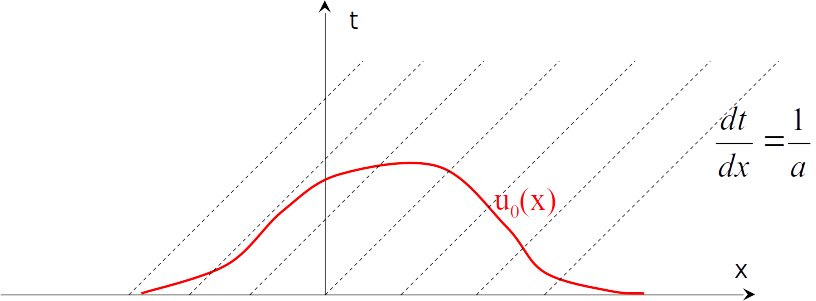

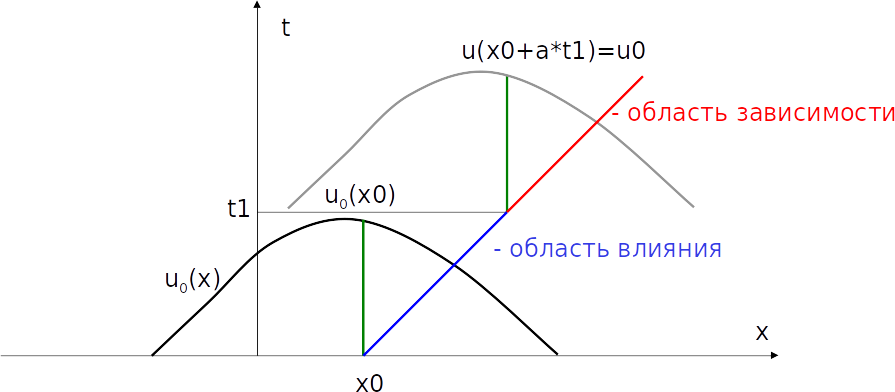

Существуют характеристики (кривые в пространстве x,t), которые зависят от $a$ и вдоль которых значения сохраняются неизменными!

## Схемы аппроксимации:

$$\int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

Схема с разностями против потока (левый уголок) : ${u_i^{n+1} - u_i^n \over \Delta t}  + a{u_i^n - u_{i-1}^n \over \Delta x} = 0$ 

или для метод контрольного объема (upwind OpenFOAM): ${u_i^{n+1} - u_i^n \over \Delta t}  \Delta x  + a (u_i^n - u_{i-1}^n) = 0$

<table><tr>
<td> <img src=attachment:image.png width="300" height="200"> </td>
<td> <img src=attachment:image-4.png width="500" height="200"> </td>
</tr></table>

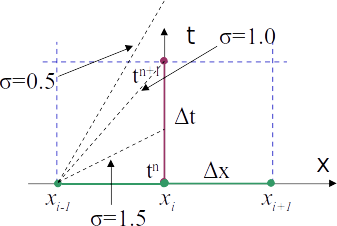

Схема с разностями по потоку (правый уголок) : ${u_i^{n+1} - u_i^n \over \Delta t}  + a{u_{i+1}^n - u_{i}^n \over \Delta x} = 0$

или для метод контрольного объема (downwind OpenFOAM): ${u_i^{n+1} - u_i^n \over \Delta t}  \Delta x  + a (u_{i+1}^n - u_{i}^n) = 0$
<table><tr>
<td> <img src=attachment:image-2.png width="300" height="200"> </td>
<td> <img src=attachment:image-5.png width="300" height="200"> </td>
</tr></table>

Схема с центральной разностью : ${u_i^{n+1} - u_i^n \over \Delta t}  + a{u_{i+1}^n - u_{i-1}^n \over 2 \Delta x} = 0$

или для метод контрольного объема (linear OpenFOAM): ${u_i^{n+1} - u_i^n \over \Delta t}  \Delta x  + a (u_{i+1}^n + u_{i}^n - u_{i}^n - u_{i-1}^n)/2  = 0$

<table><tr>
<td> <img src=attachment:image-3.png width="300" height="200"> </td>
<td> <img src=attachment:image-6.png width="300" height="200"> </td>
</tr></table>

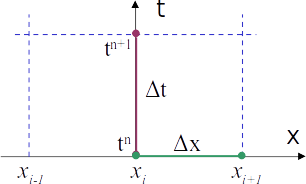
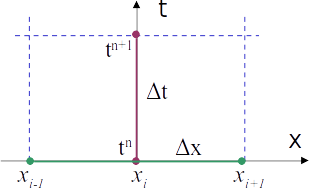
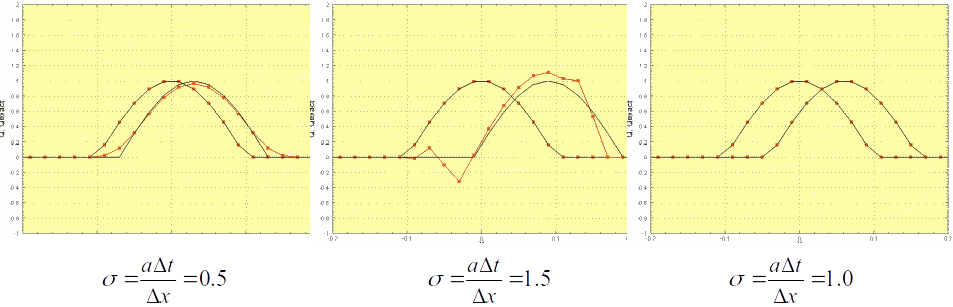
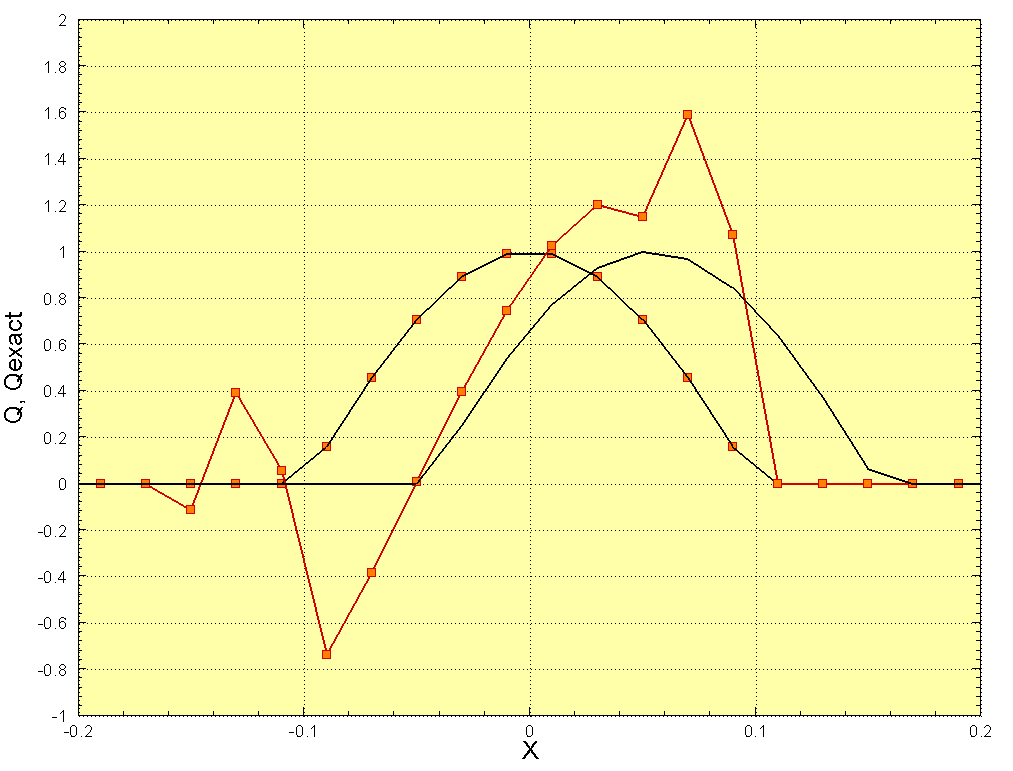
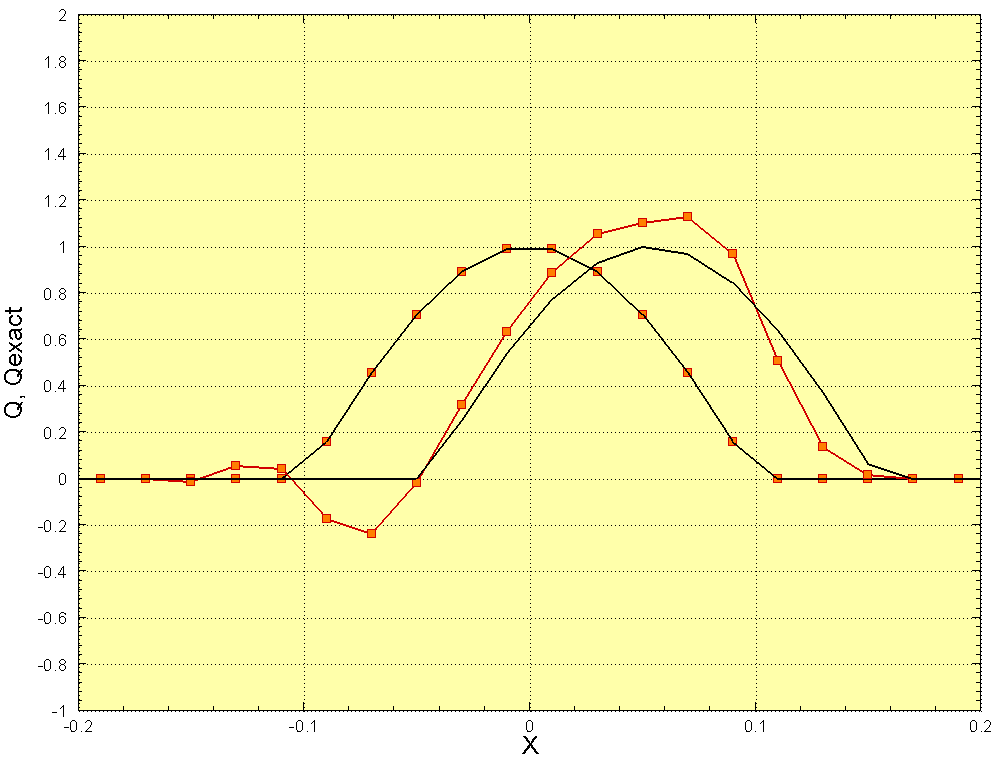
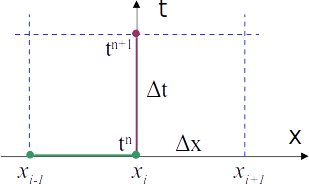

Схема КИР (Куранта Изаксона Риса): ${u_i^{n+1} - u_i^n \over \Delta t}  + (|a|+a)/2{u_i^n - u_{i-1}^n \over \Delta x} + (|a|-a)/2{u_{i+1}^n - u_{i}^n \over \Delta x} = 0$

или ${u_i^{n+1} - u_i^n \over \Delta t} \Delta x  + (|a|+a)/2(u_i^n - u_{i-1}^n ) + (|a|-a)/2(u_{i+1}^n - u_{i}^n ) = 0$

или если $f_{i+1/2} = au_{i+1/2} = {a \over 2}(u_{i+1}+u_{i})- {|a| \over 2}(u_{i+1} - u_{i})$

то ${u_i^{n+1} - u_i^n \over \Delta t} \Delta x + f_{i+1/2}^n-f_{i-1/2}^n = 0$

В зависимости от знака $a$ - "правый" или "левый" уголок

или значение для поток справа или слева

[Холодов, Нелинейные вычислительные процессы](https://mipt.lectoriy.ru/course/Maths-NonlinearComputationalProcesses-07L)

## Монотонность численных схем
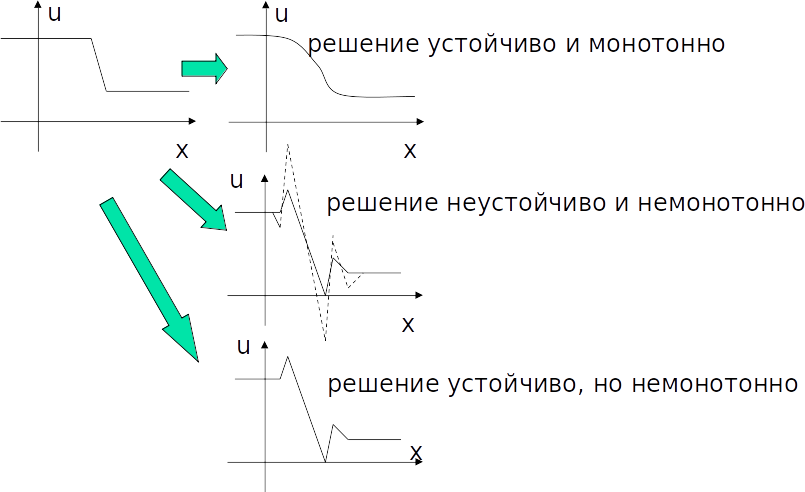
Численная схема является монотонной, если решение на временном слое
$(n+1) - u_i^{n+1}$ не выходит за диапазон значений решения $u_i^n$ на слое $n$

Теорема Годунова (1959). Любая ЛИНЕЙНАЯ монотонная схема для уравнения конвекции имеет 
первый порядок по пространству. (Для уравнения конвекции не существует ЛИНЕЙНЫХ монотонных схем выше 1го порядка)

* Линейные схемы первого порядка могут быть монотонными, но они 
очень диссипативны.
* Линейные схемы второго (и выше) порядка низкодиссипативны, но немонотонны.
* Для адекватного разрешения уравнений необходимы монотонные схемы высокого порядка.
* Только НЕЛИНЕЙНЫЕ схемы высокого порядка могут быть монотонными

## TVD схемы

TVD - total variation diminishing, неубывание полной вариации

$$TV(u(x)) = \int |u'| dx$$

$$TV(u^n) = \sum_j | u_{j+1}^n- u_j^n| $$

* Схема является TVD, если $TV(u^n) \leq TV(u^{n+1})$ Harten (1983)
* Если схема обладает TVD-свойством, то она монотонная

$\Psi(r_i)$ - функция лимитер

$r = {u_{i+1}-u_i \over u_i - u_{i-1}}$ - величина отношения градиентов в соседних ячейках

* Выбираем базовую монотонную схему 1-го порядка (например, схема с разностями против потока upwind)
* Записываем схему высокого порядка в виде суммы базовой монотонной схемы (upwind) + добавочные члены обеспечивающие более высокий порядок (linear)
* Умножаем добавочные члены на функцию (функции) Ψ(r)
* Записываем условия монотонности, чтобы определить вид функции Ψ(r)

Главное: Функция лимитера контролирует порядок схемы (1 или 2й) в зависимости от локальных особенностей решения

Диаграмма Свеби
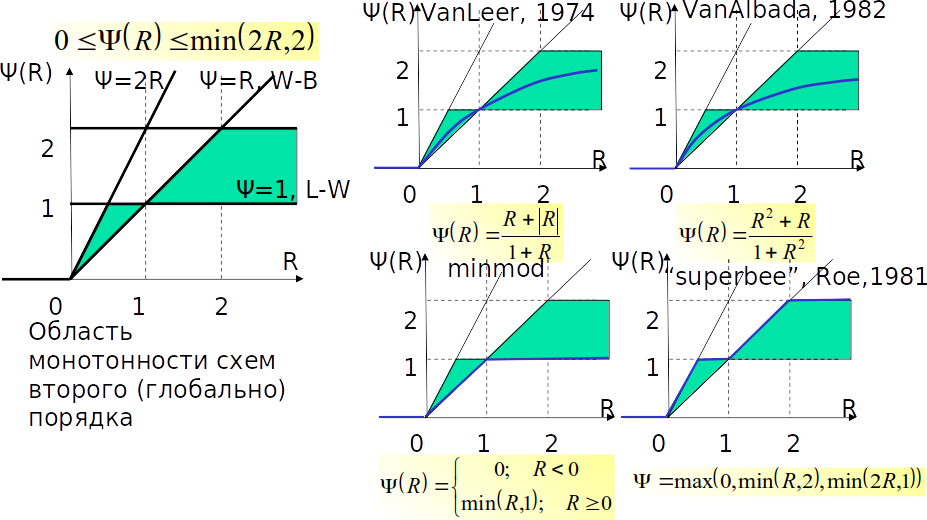

## OpenFOAM интерполяция

$$div (\rho \phi \vec{U})_C V_C \approx \int_V \nabla \cdot \left(\rho \phi \vec{U} \right) dV \approx
\sum\limits_{face} \left(\rho \phi \vec{n} \cdot \vec U \right)_f S_f$$

[OpenFOAM doxygen div](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-divergence.html)

```c++
divSchemes
{
    default         none;
    div(phi, Q)     Gauss <interpolation scheme>; //upwind, linear, Minmod, vanLeer, linearUpwind gradQ
    // div(phi)
}
// phi - surfaceScalarField значение на грани
// Q - volScalarField - значение в центрах объемов
// <interpolation scheme> - схема интерполяции Q из центра объемов на грань в зависимости от знака phi на грани
interpolationSchemes
{
    default         none;
    <equation term> <interpolation scheme>;
}
```

In [12]:
!ls $WM_PROJECT_DIR/src/finiteVolume/interpolation/surfaceInterpolation/limitedSchemes

blended		 Limited01			    Minmod     SFCD
filteredLinear	 limitedCubic			    MUSCL      SuperBee
filteredLinear2  limitedLinear			    OSPRE      UMIST
filteredLinear3  LimitedScheme			    Phi        upwind
Gamma		 limitedSurfaceInterpolationScheme  PhiScheme  vanAlbada
Limited		 limitWith			    QUICK      vanLeer


In [13]:
# upwind - интерполяция с 0м порядком в зависимости от знака phi на грани ()
!cat $WM_PROJECT_DIR/src/finiteVolume/interpolation/surfaceInterpolation/limitedSchemes/upwind/upwind.H

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2017 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General P

In [14]:
# 1D
!cat $WM_PROJECT_DIR/src/finiteVolume/interpolation/surfaceInterpolation/limitedSchemes/Minmod/Minmod.H

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public

In [15]:
# 1D
!cat $WM_PROJECT_DIR/src/finiteVolume/interpolation/surfaceInterpolation/limitedSchemes/vanLeer/vanLeer.H

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public

In [16]:
# 3D
# T_f = T_c + limiter*gradT_c * R_cf
!cat $WM_PROJECT_DIR/src/finiteVolume/interpolation/surfaceInterpolation/schemes/linearUpwind/linearUpwind.C

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2011-2016 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General P

### Вычисление градиента

$$\int_V \nabla \cdot \left(\Gamma \nabla \phi \right) dV = 
\oint_S \left(\Gamma \nabla \phi  \cdot \vec{n} \right) dS \approx
\sum\limits_{face} \left(\Gamma \nabla \phi  \cdot \vec{n} \right)_f S_f$$

$$\nabla \cdot \phi_V$$

volScalarField

[F. Moukalled; L. Mangani; M. Darwish](../books/darwish.pdf) p 273 (298)

[Gradient schemes](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient.html)
```c++
gradSchemes
{
    default         none;
    grad(p)         <optional limiter> <gradient scheme> <interpolation scheme>;
}
```

Gradient schemes

* [Gauss gradient scheme](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient-gauss.html)
* [Least-squares gradient scheme](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient-least-squares.html)

Interpolation schemes

* linear: cell-based linear
* pointLinear: point-based linear
* leastSquares: Least squares


* [Gauss gradient scheme](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient-gauss.html)
$$\int_V \left( \nabla \vec u \right) dV = \oint_S \left( \vec{n} \cdot \vec u \right) dS 
\approx \sum\limits_{face} \left(\vec u \cdot \vec{n} \right)_f S_f$$

```c++
gradSchemes
{
    default         none;
    grad(U)         leastSquares; //
    // grad(U) pointCellsLeastSquares
    // grad(U) edgeCellsLeastSquares
}
```


[F. Moukalled; L. Mangani; M. Darwish least-squares](../books/darwish.pdf) p 286 (311)
[Least-squares gradient scheme](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient-least-squares.html)
 
 ```c++
gradSchemes
{
    default         none;
    grad(U)         Gauss <interpolation scheme>;
}
```

 [cellLimited scheme](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient-cell-limited.html)
 
 ```c++
gradSchemes
{
    default         none;
    grad(U)         cellLimited<VenkatakrishnanGradientLimiter> <scheme> <coefficient>;
    // grad(U)         faceLimited <scheme> <coefficient>;
    // grad(U)         cellLimited <scheme> <coefficient>;
    // grad(U)         cellMDLimited <scheme> <coefficient>;
    // grad(U)         faceMDLimited <scheme> <coefficient>;

}
```
[Gauss vs Least-squares](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-gradient-example.html)

In [17]:
# лимитеры градиента
!ls $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/gradSchemes/limitedGradSchemes/cellLimitedGrad/gradientLimiters

cubicGradientLimiter.H	 VenkatakrishnanGradientLimiter.H
minmodGradientLimiter.H


In [18]:
# cellLimited = MinMod 3D = Barth-Jespersen
!cat $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/gradSchemes/limitedGradSchemes/cellLimitedGrad/gradientLimiters/minmodGradientLimiter.H

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2018 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public

In [19]:
# cellLimited<Venkatakrishnan> - дифференциируемый лимитер 3D
!cat $WM_PROJECT_DIR/src/finiteVolume/finiteVolume/gradSchemes/limitedGradSchemes/cellLimitedGrad/gradientLimiters/VenkatakrishnanGradientLimiter.H

/*---------------------------------------------------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     |
    \\  /    A nd           | www.openfoam.com
     \\/     M anipulation  |
-------------------------------------------------------------------------------
    Copyright (C) 2018 OpenFOAM Foundation
-------------------------------------------------------------------------------
License
    This file is part of OpenFOAM.

    OpenFOAM is free software: you can redistribute it and/or modify it
    under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    OpenFOAM is distributed in the hope that it will be useful, but WITHOUT
    ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public

[Сравнение схем OpenFOAM](https://www.openfoam.com/documentation/guides/latest/doc/guide-schemes-divergence-example.html)

## Заключение <a name="finish"></a>

1. [dynamicMotionSolverFvMesh](#motion)
2. [Конвекция](#conv)
3. [Градиент](#grad)

## В следующей серии ...

Неявная схема аппроксимации конвективного слагаемого, Граничные условия, Нелинейность! 

<table><tr>
<td> <img src="img/implicit.jpg" width="500" height="200"> </td>
<td> <img src="img/nonlinear.jpg" width="400" height="200"> </td>
</tr></table>
